## Fraud Identification from Enron Email and Financial Data

### Introduction
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives.

### The goal
The goal of the project is to use machine learning to build a predictive model to identity persons of interest (POI) who may be involved in the fraud, based on the financial and email data.In this I built a classifier on the training dataset, and then the classifier can be used to made predictions on the testing dataset

### Dataset overview
The original dataset contains 146 data points and 21 features. 18 of them are identified as POI, and the rest 128 are not POIs. The features fall into three major types, namely financial features such as “salary”, “bonus” email features such as “to messages”, “email address” and POI labels.The size of dataset is 2.23 GB.

In [3]:
import pandas as pd
import pickle
import sys
import numpy as np
import sys 
import random
import matplotlib.pyplot as plt
from time import time
from numpy import mean


sys.path.append("../tools/")

In [4]:
# Importing SK-learn specific functions 

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn import cross_validation
from sklearn.metrics import *
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

/Users/dantili/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dantili/miniconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
with open('ud120-projects/final_project/final_project_dataset.pkl','rb') as f:
    enron_data = pickle.load(f)

## 1. Exploratory Data Analysis
### Dataset Overview

In [6]:
#Total number of people in dataset 
total_people = len(enron_data)
print "Total number of people in dataset:",len(enron_data)

#Total number of features per person
Total_features_per_person = len(enron_data["ALLEN PHILLIP K"])
print "Total number of features per person:",Total_features_per_person

Total number of people in dataset: 146
Total number of features per person: 21


In [7]:
enron_data["ALLEN PHILLIP K"].keys()

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

In [8]:
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
                 'expenses', 'exercised_stock_options', 'long_term_incentive',
                 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person',
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


19 features are selected here. I excluded the feature "other" and "email_address" because "other" is the number of emails the people send to others not poi. For "email_address", it doesn't contain any new information other than the name.

### Number of POI

In [9]:
num_poi = 0
for person in enron_data:
    if enron_data[person]["poi"] == True:
        num_poi += 1

print "Number of poi in the dataset:",num_poi
print "Number of poi in the dataset who is not poi:",len(enron_data)-num_poi

Number of poi in the dataset: 18
Number of poi in the dataset who is not poi: 128


### remove outliers

In [29]:
features_outlier = ["salary","bonus"]
data = featureFormat(enron_data,features_outlier)

In [25]:
data[:3]

array([[  365788.,   600000.],
       [  267102.,  1200000.],
       [  170941.,   350000.]])

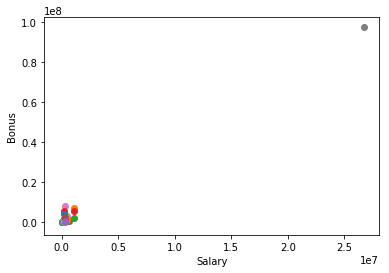

In [28]:
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary,bonus)

#labeling x-axis as salary
plt.xlabel("Salary")

#labeling y-axis as bonus
plt.ylabel("Bonus")

#Plotting scatterplot
plt.show()

From the scatterplot we can find out that there is an outlier which has a salary and bonus value way more than the rest of the data points.
For salary I will take thrashold of 5 million dollars and see which data points of salary has a value greater than 5 million dollars.

In [10]:
# Looking for an outlier 
for person,value in enron_data.items():
    if value["salary"] != "NaN" and value["salary"] > 5000000:
        print person

TOTAL


So we found out that outlier is "TOTAL" which is not a person but a total of all the data points . And we will remove it.

### Removing outliers

In [11]:
enron_data.pop("TOTAL",0)

print "Number of data points after removing outliers is:",len(enron_data)

Number of data points after removing outliers is: 145


### Scatterplot After removing outliers

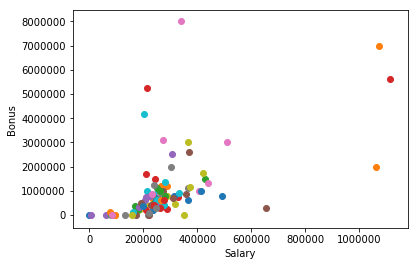

In [13]:
features_outlier = ["salary","bonus"]
data = featureFormat(enron_data,features_outlier)
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter(salary,bonus)

#labeling x-axis as salary
plt.xlabel("Salary")

#labeling y-axis as bonus
plt.ylabel("Bonus")

#Plotting scatterplot
plt.show()

From the dataset, we can see that 3 people recieved salary more than 1 million dollars annually. Around 5 people got more than half a million dollars as bonus.

## 2. Feature Engineering

I started with all the features except “email_address” and “other”, because email address is a text string corresponding to a person’s name, “other” does not add any meaning to the analysis. I created two new features “from_poi_to_this_person_ratio” which measures how frequently a poi sends email to this person and “from_this_person_to_poi_ratio” which measures how frequently this person sends email to poi.

In [14]:
#Creating new variables
#from_poi_to_this_person_ratio 

#making copy of dataset
dataset = enron_data

#iterating through the dict
for key,value in dataset.iteritems():
    value["from_poi_to_this_person_ratio"] = 0
    if value["to_messages"] and value["from_poi_to_this_person"] !="NaN" and value["from_poi_to_this_person"] > 0:
        value["from_poi_to_this_person"] = float(value["from_poi_to_this_person"])
        value["to_messages"] = float(value["to_messages"])
        value["from_poi_to_this_person_ratio"] = value["from_poi_to_this_person"]/value["to_messages"]

In [15]:
#Creating new variables
#from_this_person_to_poi 

#iterating through the dict
for key,value in dataset.iteritems():
    value["from_this_person_to_poi_ratio"] = 0
    if value["from_messages"] and value["from_this_person_to_poi"] !="NaN" and value["from_this_person_to_poi"] > 0:
        value["from_this_person_to_poi"] = float(value["from_this_person_to_poi"])
        value["from_messages"] = float(value["from_messages"])
        value["from_this_person_to_poi_ratio"] = value["from_this_person_to_poi"]/value["from_messages"]

In [16]:
#Appending these two new features to our feature list
features_list.append('from_poi_to_this_person_ratio')
features_list.append('from_this_person_to_poi_ratio')

### Missing values

In [21]:
#creating a list of zeros having length equal to the number of features#creating 
nan = [0] * (len(features_list))

for i, person in dataset.iteritems():
    for j, feature in enumerate(features_list):
        if person[feature] == 'NaN':
            nan[j] += 1
            
print nan
print features_list
            

[0, 51, 107, 21, 142, 64, 128, 97, 20, 51, 44, 80, 36, 129, 59, 59, 59, 59, 59, 0, 0]
['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'from_poi_to_this_person_ratio', 'from_this_person_to_poi_ratio']


### Extract features

In [22]:
#Extract features and labels from dataset#Extract  
data = featureFormat(dataset, features_list, sort_keys = True)
labels,features = targetFeatureSplit(data)

### Feature Scaling
I performed feature scaling using MinMaxScaler model to makes sure that the features would be weighted equally before applying to machine learning algorithm classifier.

In [25]:
# Scale features via min-max# Scale f 
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

## 3. Algorithms (model) Selection
* Random Forest
* K Nearest Neighbors

I ran SelectKBest for all values from K1 to K20 manually for all selected models and recorded value on KBest, precision and recall, then generated the plots as follows.

### GaussianNB

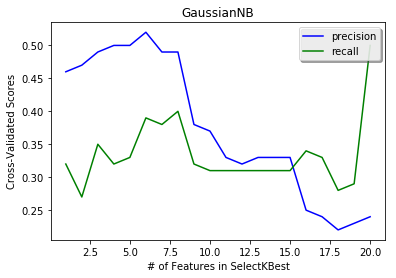

In [35]:
# Using SelectKBest with k having a value of 6
selection=SelectKBest(k=6)
selection.fit(features, labels)

# GaussianNB feature selection
kbest_g = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

#Precision value respect to the value of k
precision_g =[0.46, 0.47, 0.49, 0.5, 0.5, 0.52, 0.49, 0.49, 0.38, 0.37, 0.33, 0.32,0.33, 0.33, 0.33, 0.25, 0.24, 0.22, 0.23, 0.24]

#recall value respect to the value of k
recall_g = [0.32, 0.27, 0.35, 0.32, 0.33, 0.39, 0.38, 0.40, 0.32, 0.31, 0.31, 0.31,0.31, 0.31, 0.31, 0.34, 0.33, 0.28, 0.29, 0.50]

#generating the line graph 
plt.plot(kbest_g, precision_g, 'b', label='precision')
plt.plot(kbest_g, recall_g, 'g', label='recall')
legend = plt.legend(loc='upper right', shadow=True)
plt.xlabel('# of Features in SelectKBest')
plt.ylabel('Cross-Validated Scores')
plt.title('GaussianNB')
plt.show()

### Random Forest

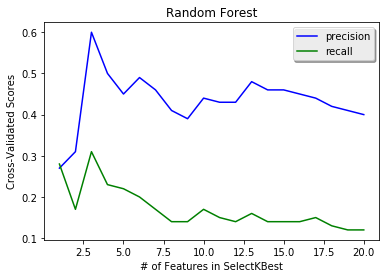

In [32]:
# Random Forest feature selection
kbest_r=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

#Precision value respect to the value of k
precision_r = [0.27, 0.31, 0.60, 0.50, 0.45, 0.49, 0.46, 0.41, 0.39, 0.44, 0.43, 0.43,0.48, 0.46, 0.46, 0.45, 0.44, 0.42, 0.41, 0.40]

#recall value respect to the value of k
recall_r = [0.28, 0.17, 0.31, 0.23, 0.22, 0.20, 0.17, 0.14, 0.14, 0.17, 0.15, 0.14,0.16, 0.14, 0.14, 0.14, 0.15, 0.13, 0.12, 0.12]

#generating the line graph 
plt.plot(kbest_r, precision_r, 'b', label='precision')
plt.plot(kbest_r, recall_r, 'g', label='recall')
legend = plt.legend(loc='upper right', shadow=True)
plt.xlabel('# of Features in SelectKBest')
plt.ylabel('Cross-Validated Scores')
plt.title('Random Forest')
plt.show()

From the line graph it can be seen that for k = 3 Random forest performance is the best, with Precision as 0.60 and Recall as 0.31


### K Nearest Neighbors

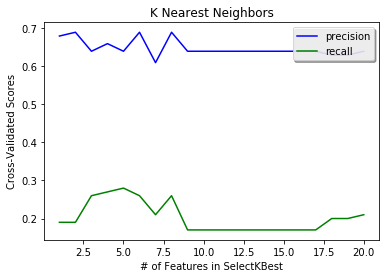

In [33]:
#K Nearest Neighbors feature selection
kbest_k=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

#Precision value respect to the value of k
precision_k = [0.68, 0.69, 0.64, 0.66, 0.64, 0.69, 0.61, 0.69, 0.64, 0.64, 0.64, 0.64,0.64, 0.64, 0.64, 0.64, 0.64, 0.63, 0.63, 0.64]

#recall value respect to the value of k
recall_k = [0.19, 0.19, 0.26, 0.27, 0.28, 0.26, 0.21, 0.26, 0.17, 0.17, 0.17, 0.17,0.17, 0.17, 0.17, 0.17, 0.17, 0.2, 0.2, 0.21]

#generating the line graph 
plt.plot(kbest_k, precision_k, 'b', label='precision')
plt.plot(kbest_k, recall_k, 'g', label='recall')
legend = plt.legend(loc='upper right', shadow=True)
plt.xlabel('# of Features in SelectKBest')
plt.ylabel('Cross-Validated Scores')
plt.title('K Nearest Neighbors')
plt.show()

From the line graph it can be seen that for k = 5 K Nearest Neighbors performance is the best, with Precision as 0.64 and Recall as 0.28

After testing all three algorithms, I found that k6 is the sweet spot for GaussianNB. I ended up selecting Gaussian NB as the best performer because it has the better recall than the alternatives.

## 4.Parameter Tuning

For parameter tuning, I used GridSearch.

In [38]:
#coverting dataset again into labels and features#covertin 
#w.r.t. to new features list
features_list = ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus',
                 'salary', 'from_this_person_to_poi_ratio', 'deferred_income']
data = featureFormat(dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

### GaussianNB
For this part, I don't need to tune parameters.

In [39]:
# Classifier 
clf = GaussianNB()

#Doing a fit operation with feature_train and label_train
clf.fit(features_train, labels_train)

#Making prediction with classifier on feature test
pred = clf.predict(features_test)

#Accuracy 
accu = accuracy_score(pred,labels_test)
print "accuracy: ", accu

#precision value 
print 'precision = ', precision_score(labels_test,pred)

#recall value
print 'recall = ', recall_score(labels_test,pred)

accuracy:  0.880952380952
precision =  0.6
recall =  0.5


### KNN
After Using GridSearch, best set of feature for KNN is :{"n_neighbors":[2, 5], "p":[2,3]}

In [40]:
# KNeighbors classifier
clf = KNeighborsClassifier()

#splitting the data into features_train, features_test, labels_train, labels_test 
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test =train_test_split(features, labels, test_size=0.3, random_state=42)

#applying GridSearchCV
tuned_parameters_knn = {"n_neighbors":[2, 5], "p":[2,3]}
clf=GridSearchCV(clf, tuned_parameters_knn)

#fitting the features_train and labels_train to classifier
clf.fit(features_train, labels_train)

#Making prediction with classifier on feature test
pred = clf.predict(features_test)

#Accuracy 
accu = accuracy_score(pred,labels_test)
print "accuracy: ", accu

#precision value 
print 'precision = ', precision_score(labels_test,pred)

#recall value
print 'recall = ', recall_score(labels_test,pred)

accuracy:  0.857142857143
precision =  0.0
recall =  0.0


/Users/dantili/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random Forest
The best set of feature is:

{"n_estimators":[2, 3, 5], "criterion": ('gini', 'entropy')}

In [41]:
# Random Forest
clf = RandomForestClassifier()

#splitting the data into features_train, features_test, labels_train, labels_test 
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

#applying GridSearchCV
tuned_parameters_ran = {"n_estimators":[2, 3, 5],  "criterion": ('gini', 'entropy')}
clf = GridSearchCV(clf, tuned_parameters_ran)

#fitting the features_train and labels_train to classifier
clf.fit(features_train, labels_train)

#Making prediction with classifier on feature test
pred = clf.predict(features_test)

#Accuracy
accu = accuracy_score(pred,labels_test)
print "accuracy: ", accu

#precision value 
print 'precision = ', precision_score(labels_test,pred)

#recall value
print 'recall = ', recall_score(labels_test,pred)

accuracy:  0.857142857143
precision =  0.5
recall =  0.166666666667


## Summary

For this project, I use precision and recall as the main evaluation metrics, Gaussian Naïve Bayes achieved the best results – precision: 0.6 and recall: 0.5. This is the final model as well. Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples. In this case, if my algorithm predicts a person is a POI, about 60% of time this person is indeed a POI. And my algorithm can identify a POI correctly about 50% of the time.

## References

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
https://github.com/namansharma0992/Fraud-Identification-from-Enron-Email-and-Financial-Data/blob/master/Fraud%20Identification%20from%20Enron%20Email%20and%20Financial%20Data.ipynb
https://github.com/thuyquach/Identify-Fraud-from-Enron-Email/blob/master/Identify%20Fraud%20from%20Enron%20Dataset.ipynb
https://www.kaggle.com/wcukierski/enron-email-dataset
